In [62]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

from sklearn.model_selection import PredefinedSplit

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [63]:
X_train_encoded = pd.read_csv('datasets/scaled_data_train_delivery1.csv', index_col=0)
y_train_encoded = pd.read_csv('datasets/scaled_target_train_delivery1.csv', index_col=0)
X_val_encoded = pd.read_csv('datasets/scaled_data_val_delivery1.csv', index_col=0)
y_val_encoded = pd.read_csv('datasets/scaled_target_val_delivery1.csv', index_col=0)
X_test_encoded = pd.read_csv('datasets/scaled_data_test_delivery1.csv', index_col=0)

In [64]:
X_test_encoded.head()

,Age at Injury,Average Weekly Wage,Birth Year,Number of Dependents,Accident Year,C-2 Date Year,Assembly Year,Dependency-to-Income Ratio,Time Between Events,Carrier Accident Density,...,COVID-19 Indicator,First Hearing Date,Gender,Frequent Injury Cause,Accident on Weekday,Both C2 and C3,C-3 Date,Only C2,Only C3,No C2 or C3
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6165911,0.046154,0.305485,0.956522,0.166667,1.0,0.928571,1.5,5.765798e-03,0.083333,0.081122,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6166141,0.046154,0.305485,0.956522,0.166667,1.0,0.928571,1.5,5.765798e-03,0.083333,0.114068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6165907,0.661538,-0.004846,0.376812,0.000000,1.0,0.857143,1.5,0.000000e+00,0.083333,0.003564,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6166047,30.861538,-0.004846,-28.072464,1.000000,1.0,0.928571,1.5,3.088000e+10,0.083333,0.130524,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6166102,0.138462,-0.004846,0.869565,0.833333,1.0,0.857143,1.5,2.573333e+10,0.083333,0.113837,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#Shape of the datasets
print('X_train shape:', X_train_encoded.shape, 'y_train shape:', y_train_encoded.shape)
print('X_val shape:', X_val_encoded.shape, 'y_val shape:', y_val_encoded.shape)
print('X_test shape:', X_test_encoded.shape)

X_train shape: (441804, 91) y_train shape: (441804, 1)
X_val shape: (110586, 91) y_val shape: (110586, 1)
X_test shape: (387975, 91)


In [66]:
#Keep the columns in x_test that are in x_val
X_test_encoded = X_test_encoded[X_val_encoded.columns]

In [67]:
X_train_encoded.columns

Index(['Age at Injury', 'Average Weekly Wage', 'Birth Year',
       'Number of Dependents', 'Accident Year', 'C-2 Date Year',
       'Assembly Year', 'Dependency-to-Income Ratio', 'Time Between Events',
       'Carrier Accident Density', 'Industry Claim Percentage',
       'Region Risk Percentage', 'Geo-Industry Risk', 'Carrier Type_2A. SIF',
       'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE',
       'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)',
       'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS',
       'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN',
       'District Name_BINGHAMTON', 'District Name_BUFFALO',
       'District Name_HAUPPAUGE', 'District Name_NYC',
       'District Name_ROCHESTER', 'District Name_STATEWIDE',
       'District Name_SYRACUSE', 'Medical Fee Region_2',
       'Medical Fee Region_3', 'Medical Fee Region_4', 'Age Group_Old',
       'Age Group_Other', 'Age Group_Young', 'Broad Body Part_Internal 

In [68]:
numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year',
                    'Assembly Year', 'Dependency-to-Income Ratio', 'Time Between Events','C-2 Date Year',
                    'Carrier Accident Density', 'Industry Claim Percentage', 'Region Risk Percentage', 'Geo-Industry Risk']
                    
categorical_features = ['Age Group_Old', 'Age Group_Other', 'Age Group_Young', 'Broad Body Part_Internal Organs', 
                        'Broad Body Part_Lower Extremities', 'Broad Body Part_Multiple Body Parts', 'Broad Body Part_Trunk', 
                        'Broad Body Part_Unclassified', 'Broad Body Part_Unknown', 'Broad Body Part_Upper Extremities', 'Broad Body Part_Whole Body',
                        'Carrier Name_1. CANCELLED', 'Carrier Name_2. NON-COMP', 'Carrier Name_3. MED ONLY', 'Carrier Name_4. TEMPORARY',
                        'Carrier Name_5. PPD SCH LOSS', 'Carrier Name_6. PPD NSL', 'Carrier Name_7. PTD', 'Carrier Name_8. DEATH', 'Carrier Type_2A. SIF',
                        'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)', 
                        'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS', 'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN', 
                        'County of Injury_1. CANCELLED', 'County of Injury_2. NON-COMP', 'County of Injury_3. MED ONLY', 
                        'County of Injury_4. TEMPORARY', 'County of Injury_5. PPD SCH LOSS', 'County of Injury_6. PPD NSL', 'County of Injury_7. PTD', 
                        'County of Injury_8. DEATH', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 
                        'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Industry Risk Level_Low Risk', 
                        'Industry Risk Level_Medium Risk', 
                        'Injury-Location Pair_1. CANCELLED', 'Injury-Location Pair_2. NON-COMP', 'Injury-Location Pair_3. MED ONLY', 
                        'Injury-Location Pair_4. TEMPORARY', 'Injury-Location Pair_5. PPD SCH LOSS', 'Injury-Location Pair_6. PPD NSL', 
                        'Injury-Location Pair_7. PTD', 'Injury-Location Pair_8. DEATH', 'Medical Fee Region_2', 'Medical Fee Region_3', 
                        'Medical Fee Region_4', 'Region Risk Level_Low Risk', 'Region Risk Level_Medium Risk', 
                        'Season of Accident_Spring', 'Season of Accident_Summer', 'Season of Accident_Winter']
                        
binary_features = ['IME-4 Count','Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator', 
                   'First Hearing Date', 'Gender','Frequent Injury Cause', 'Accident on Weekday', 'Both C2 and C3', 'C-3 Date',
                   'Only C2', 'Only C3', 'No C2 or C3']

cyclic_features = ['Accident Month_sin', 'Accident Month_cos', 'Assembly Month_sin','Assembly Month_cos', 'C-2 Date Month_sin', 'C-2 Date Month_cos']


In [69]:
# Check variance of the scaled numerical features
# Split into numeric and categorical (training and test sets)
numerical_features = numeric_features + cyclic_features
categorical_features = categorical_features +  binary_features
X_train_numeric_scaled = X_train_encoded[numerical_features]
y_train_numeric_scaled = y_train_encoded.loc[X_train_numeric_scaled.index]
X_train_categorical_encoded = X_train_encoded[categorical_features]
y_train_categorical_encoded = y_train_encoded.loc[X_train_categorical_encoded.index]

X_val_numeric_scaled = X_val_encoded[numerical_features]
y_val_numeric_scaled = y_val_encoded.loc[X_val_numeric_scaled.index]
X_val_categorical_encoded = X_val_encoded[categorical_features]
y_val_categorical_encoded = y_val_encoded.loc[X_val_categorical_encoded.index]

# 4. Feature Selection

## Numerical

## **4.1 Filter Methods**

### **4.1.1. Univariate variables**

### **4.1.2 Correlation Indices**

In [70]:
# Function to plot a heatmap of the Spearman correlation matrix
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

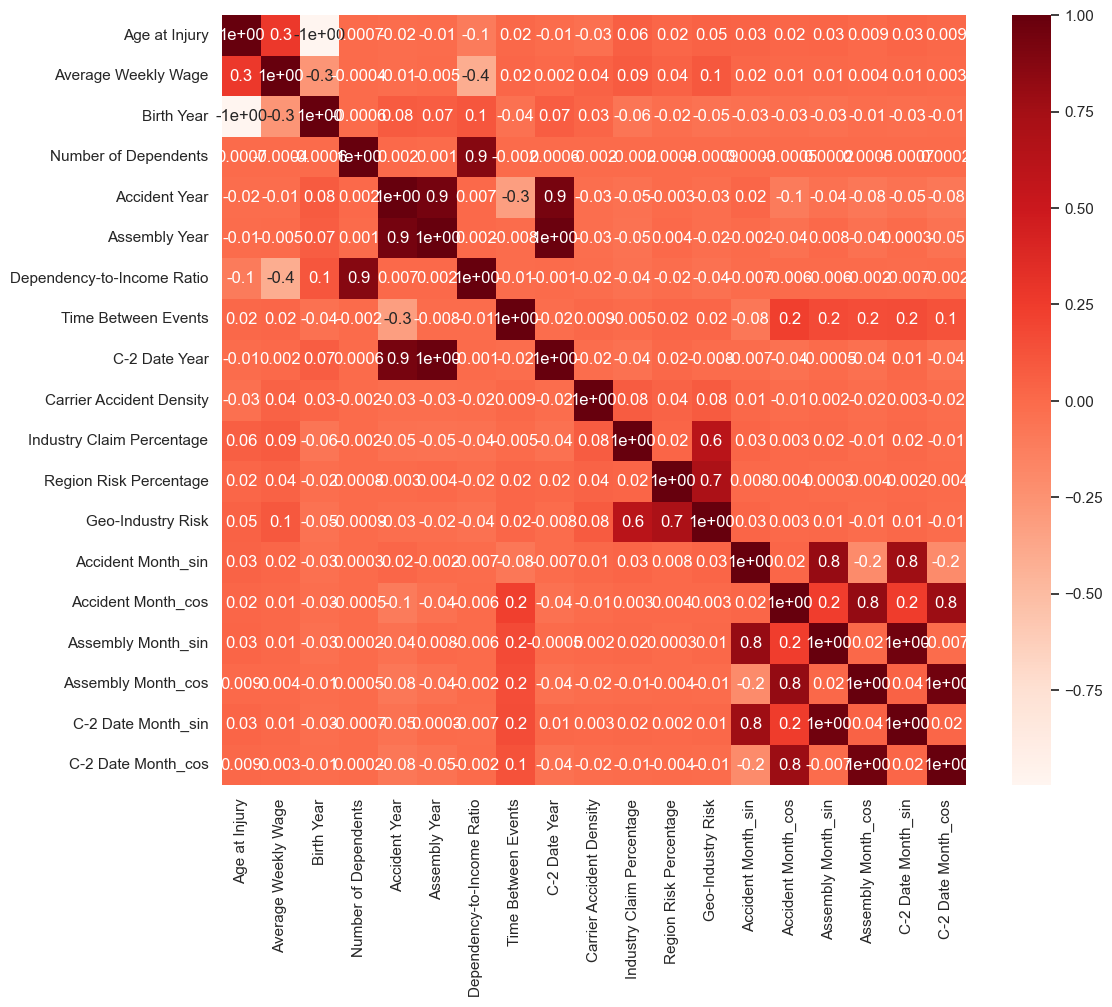

In [71]:
# Get the spearman correlation matrix
corr_spearman = X_train_numeric_scaled.corr(method='spearman')
cor_heatmap(corr_spearman)

## 4.2. Wrapper Methods

### 4.2.1. RFE

#### **4.2.1.1 RFE - Logistic Regression**

In [72]:
# Initialize the Logistic Regression model for RFE-Logistic Regression
model_LR = LogisticRegression()

# Initialize the Recursive Feature Elimination (RFE) selector
rfe_LR = RFE(estimator = model_LR, n_features_to_select = 8)

# Fit the RFE selector to the training data
X_rfe = rfe_LR.fit_transform(X = X_train_numeric_scaled, y = y_train_numeric_scaled)

# Get the selected features
rfelr_selected = X_train_numeric_scaled.columns[rfe_LR.support_]

In [73]:
rfelr_selected

Index(['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Accident Year',
       'Assembly Year', 'Dependency-to-Income Ratio', 'Time Between Events',
       'C-2 Date Year'],
      dtype='object')

#### **4.2.1.2. RFE - Cross-Validation**

In [74]:
# Combine the train and validation datasets with only numerical features
X_combined = pd.concat([X_train_numeric_scaled, X_val_numeric_scaled], axis=0)
y_combined = pd.concat([y_train_numeric_scaled, y_val_numeric_scaled], axis=0)

# Create the test_fold array
test_fold = np.concatenate([
    np.full(len(X_train_numeric_scaled), -1),  # Assign -1 for training samples
    np.full(len(X_val_numeric_scaled), 0)     # Assign 0 for validation samples
])

# Define PredefinedSplit object
cv_strategy = PredefinedSplit(test_fold)


In [75]:
print(f"X_train_numeric_scaled shape: {X_train_numeric_scaled.shape}")
print(f"y_train_numeric_scaled shape: {y_train_numeric_scaled.shape}")


X_train_numeric_scaled shape: (441804, 19)
y_train_numeric_scaled shape: (441804, 1)


In [76]:
# Perform Recursive Feature Elimination with Cross-Validation (RFE-CV)
model_CV = LogisticRegression()
rfecv = RFECV(estimator=model_CV, step=1, cv=cv_strategy, scoring='f1_macro')

# Fit RFE-CV on the combined dataset
rfecv.fit(X_combined, y_combined.values.ravel())  # Use .values.ravel() to flatten y if necessary

# Optimal score
optimal_score = max(rfecv.cv_results_['mean_test_score'])

# Optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)

# Optimal performance
print("Score with %d features: %f" % (rfecv.n_features_, optimal_score))

Optimal number of features: 13
Score with 13 features: 0.125346


In [77]:
# Print the ranking of features
# Features with a rank of 1 are the most important features selected by the RFE-CV process and higher ranks are less important
print("Feature ranking:", rfecv.ranking_)

Feature ranking: [1 1 1 1 1 1 1 1 1 1 4 3 1 1 7 2 1 6 5]


In [78]:
# Create a DataFrame with the support and ranking of features
rfecv_selected = pd.DataFrame({"support": rfecv.support_, "ranking": rfecv.ranking_}, index=X_train_numeric_scaled.columns)

# Filter the DataFrame to get only the features with a rank of 1
important_features = rfecv_selected[rfecv_selected['ranking'] == 1]

# Print the important features
print("Important features selected by RFECV:")
print(important_features)

Important features selected by RFECV:
                            support  ranking
Age at Injury                  True        1
Average Weekly Wage            True        1
Birth Year                     True        1
Number of Dependents           True        1
Accident Year                  True        1
Assembly Year                  True        1
Dependency-to-Income Ratio     True        1
Time Between Events            True        1
C-2 Date Year                  True        1
Carrier Accident Density       True        1
Geo-Industry Risk              True        1
Accident Month_sin             True        1
Assembly Month_cos             True        1


## 4.3 Embedded Methods

### **4.3.1 Lasso Regression**

In [79]:
# Initialize the Lasso model 
reg = LassoCV()

# Fit the Lasso model to the training data
reg.fit(X_train_numeric_scaled, y_train_numeric_scaled)

LassoCV()

In [80]:
# Get the coefficients of the Lasso model
coef = pd.Series(reg.coef_, index = X_train_numeric_scaled.columns)
coef

Age at Injury                  0.526343
Average Weekly Wage            0.718203
Birth Year                    -0.000000
Number of Dependents          -0.482753
Accident Year                  0.000000
Assembly Year                 -0.444265
Dependency-to-Income Ratio    14.832102
Time Between Events           -0.078669
C-2 Date Year                  1.912825
Carrier Accident Density       0.318801
Industry Claim Percentage     -0.016266
Region Risk Percentage         0.180924
Geo-Industry Risk              0.008274
Accident Month_sin            -0.022074
Accident Month_cos            -0.025062
Assembly Month_sin             0.030367
Assembly Month_cos             0.025280
C-2 Date Month_sin             0.022770
C-2 Date Month_cos            -0.069663
dtype: float64

In [81]:
# Sort the coefficients by their absolute values
sorted_coef = coef.abs().sort_values(ascending=False)

In [82]:
# Function to plot feature importance according to Lasso
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

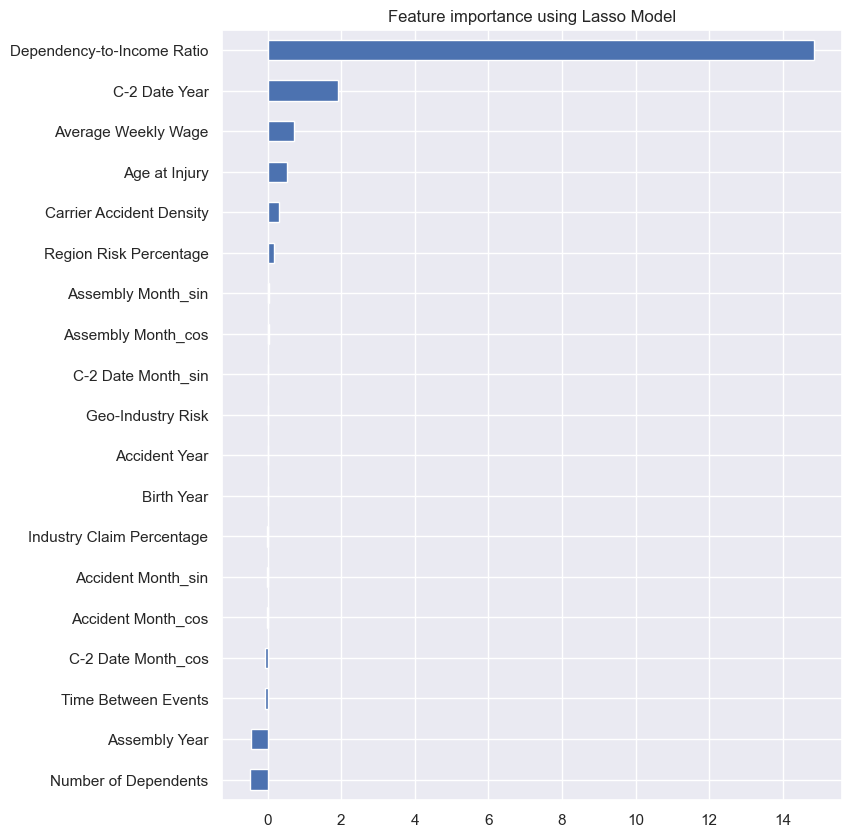

In [83]:
plot_importance(coef,'Lasso')

### **4.3.2 Decision Tree**

In [84]:
# Initialize and train a Decision Tree classifier
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_numeric_scaled, y_train_numeric_scaled)

DecisionTreeClassifier(random_state=42)

In [85]:
# Get feature importances
importances = tree_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)

                       Feature  Importance
1          Average Weekly Wage    0.296634
2                   Birth Year    0.134560
9     Carrier Accident Density    0.083615
12           Geo-Industry Risk    0.067819
6   Dependency-to-Income Ratio    0.058026
11      Region Risk Percentage    0.052280
10   Industry Claim Percentage    0.038370
13          Accident Month_sin    0.033812
0                Age at Injury    0.033560
14          Accident Month_cos    0.032440
3         Number of Dependents    0.027932
17          C-2 Date Month_sin    0.025130
18          C-2 Date Month_cos    0.025078
16          Assembly Month_cos    0.023402
15          Assembly Month_sin    0.023211
4                Accident Year    0.014546
8                C-2 Date Year    0.012022
5                Assembly Year    0.010667
7          Time Between Events    0.006897


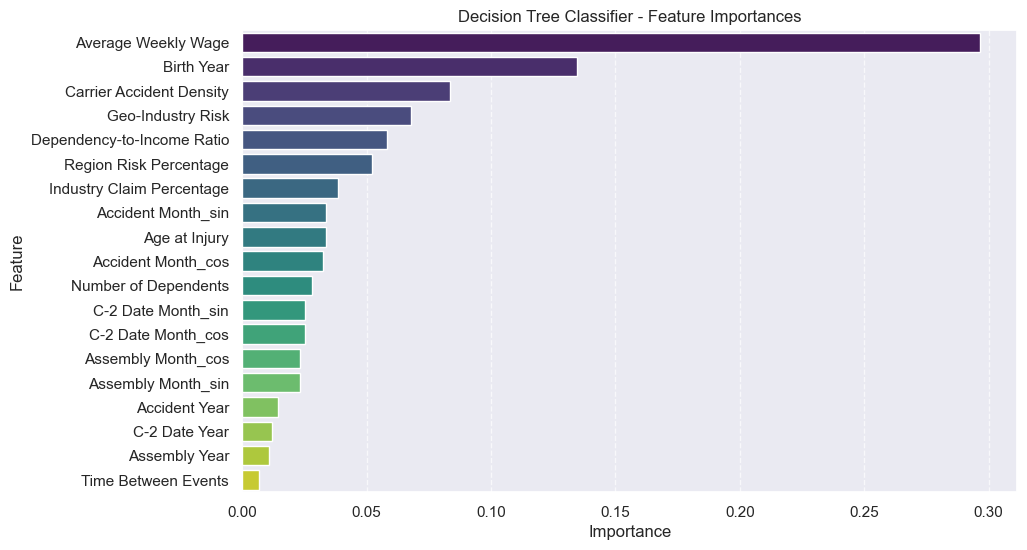

In [86]:
# Ensure 'feature_importances' DataFrame is correctly defined
feature_importances = pd.DataFrame({
	'Feature': X_train_numeric_scaled.columns,
	'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Decision Tree Classifier - Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### **4.3.3 Gradient Boosting**

In [87]:
# Initialize the GradientBoostingClassifier with a fixed random seed for reproducibility
gb_model = GradientBoostingClassifier(random_state=42)

# Fit the Gradient Boosting model on the scaled numeric training data and corresponding target values
gb_model.fit(X_train_numeric_scaled, y_train_numeric_scaled)

# Extract the feature importances from the trained model
importances = gb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort the features by importance in descending order to highlight the most important features
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame to view which features have the highest importance
print(feature_importances)


                       Feature  Importance
1          Average Weekly Wage    0.716764
2                   Birth Year    0.147963
9     Carrier Accident Density    0.068753
10   Industry Claim Percentage    0.032315
11      Region Risk Percentage    0.007165
8                C-2 Date Year    0.004240
4                Accident Year    0.004120
12           Geo-Industry Risk    0.003769
5                Assembly Year    0.003724
7          Time Between Events    0.003509
13          Accident Month_sin    0.001819
0                Age at Injury    0.001678
14          Accident Month_cos    0.001034
17          C-2 Date Month_sin    0.000975
18          C-2 Date Month_cos    0.000960
15          Assembly Month_sin    0.000859
16          Assembly Month_cos    0.000294
6   Dependency-to-Income Ratio    0.000054
3         Number of Dependents    0.000005


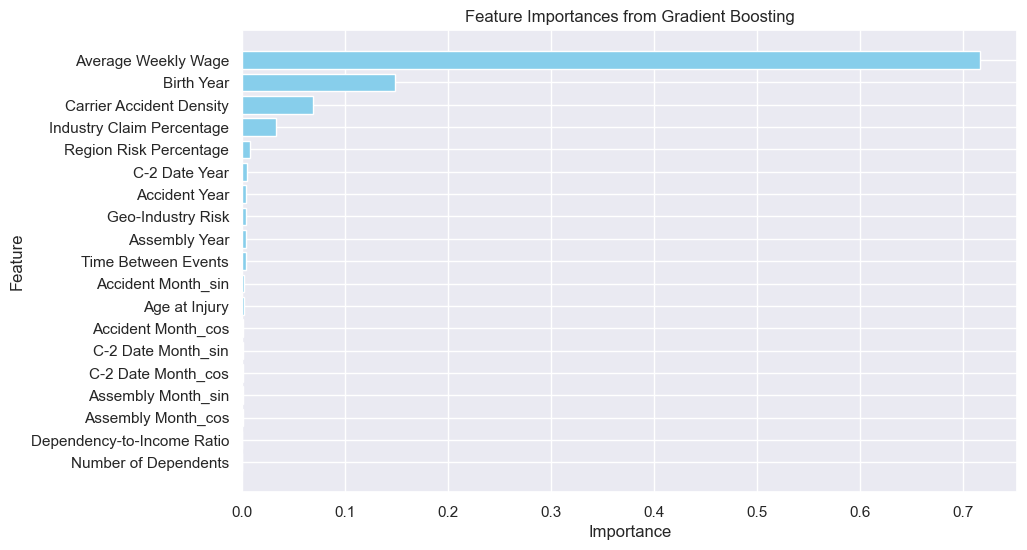

In [88]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()  # Reverse the y-axis so the most important feature is at the top
plt.show()


Maintaining the same rationale as the decision tree model, we are going to keep the features with importance value above 0.05. Which is only the Average Weekly Wage.

### **4.3.5 Random Forest**

In [89]:
# Initialize the RandomForestClassifier with a fixed random seed for reproducibility
rf_model = RandomForestClassifier(random_state=42)

# Fit the Random Forest model on the scaled numeric training data and corresponding target values
rf_model.fit(X_train_numeric_scaled, y_train_numeric_scaled)

# Extract the feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Create a DataFrame to organize the feature names and their corresponding importance scores
feature_importances_rf = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort features by importance in descending order to highlight the most important features
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame to view which features have the highest importance
print(feature_importances_rf)

                       Feature  Importance
1          Average Weekly Wage    0.216520
6   Dependency-to-Income Ratio    0.092136
2                   Birth Year    0.090703
9     Carrier Accident Density    0.080352
0                Age at Injury    0.079236
12           Geo-Industry Risk    0.068151
11      Region Risk Percentage    0.055512
10   Industry Claim Percentage    0.042462
3         Number of Dependents    0.040343
13          Accident Month_sin    0.036047
14          Accident Month_cos    0.035647
18          C-2 Date Month_cos    0.029848
17          C-2 Date Month_sin    0.029746
16          Assembly Month_cos    0.029370
15          Assembly Month_sin    0.029243
4                Accident Year    0.014136
8                C-2 Date Year    0.012759
5                Assembly Year    0.011506
7          Time Between Events    0.006282


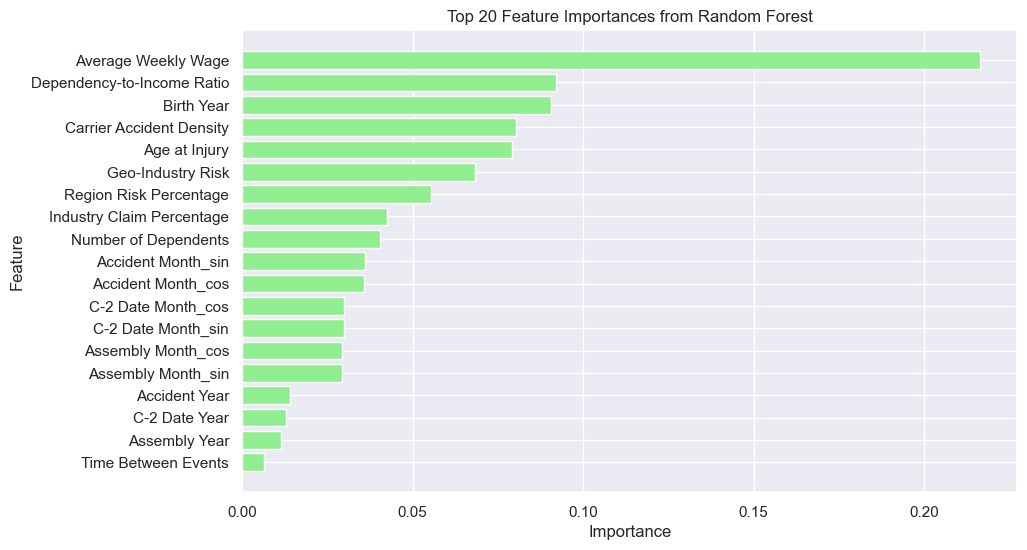

In [90]:
# plot feature importances for the first 20 features
plt.figure(figsize=(10, 6))
top_20_features = feature_importances_rf.head(20)
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # reverse the y-axis so that the most important feature is at the top
plt.show()


Keeping the 2 features with the highest importance value. The others are under 0.1, too close to 0 considering one of the features got almost 0.35


## Categorical

### **4.3.6 Chi Square**

In [91]:
# List to store chi-square test results
chi2_results = []

def TestIndependence(X, y, var, alpha=0.001):
    # Create a contingency table (observed frequencies)
    dfObserved = pd.crosstab(y, X)

    # Perform the chi-square test of independence
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)

    # Determine the importance based on the p-value
    if p < alpha:
        importance = "Important"
    else:
        importance = "Not Important"

    # Append the results to the chi2_results list
    chi2_results.append({
        'Feature': var,
        'Chi-Square Score': chi2,
        'Importance': importance
    })

    # Print the result for the feature
    print(f"{var} is {importance} for Prediction")


In [92]:
# Loop through each categorical feature in the training data
for var in X_train_categorical_encoded.columns:
    # Perform the chi-square test of independence for the current feature
    TestIndependence(X_train_categorical_encoded[var], y_train_categorical_encoded.values.ravel(), var)

Age Group_Old is Important for Prediction
Age Group_Other is Important for Prediction
Age Group_Young is Important for Prediction
Broad Body Part_Internal Organs is Important for Prediction
Broad Body Part_Lower Extremities is Important for Prediction
Broad Body Part_Multiple Body Parts is Important for Prediction
Broad Body Part_Trunk is Important for Prediction
Broad Body Part_Unclassified is Important for Prediction
Broad Body Part_Unknown is Important for Prediction
Broad Body Part_Upper Extremities is Important for Prediction
Broad Body Part_Whole Body is Important for Prediction
Carrier Name_1. CANCELLED is Important for Prediction
Carrier Name_2. NON-COMP is Important for Prediction
Carrier Name_3. MED ONLY is Important for Prediction
Carrier Name_4. TEMPORARY is Important for Prediction
Carrier Name_5. PPD SCH LOSS is Important for Prediction
Carrier Name_6. PPD NSL is Important for Prediction
Carrier Name_7. PTD is Important for Prediction
Carrier Name_8. DEATH is Important fo

In [93]:
# Convert the list of chi-square test results to a DataFrame
chi2_df = pd.DataFrame(chi2_results).sort_values(by='Chi-Square Score', ascending=False)

# Print the DataFrame containing the chi-square test results
print(chi2_df)

                                              Feature  Chi-Square Score  \
59                                        IME-4 Count     195057.824743   
61                            Attorney/Representative     168389.701870   
44                   Injury-Location Pair_2. NON-COMP     151890.699710   
46                  Injury-Location Pair_4. TEMPORARY     147287.821418   
45                   Injury-Location Pair_3. MED ONLY     136359.092488   
..                                                ...               ...   
23  Carrier Type_5C. SPECIAL FUND - POI CARRIER WC...          5.787452   
67                                     Both C2 and C3          0.000000   
69                                            Only C2          0.000000   
70                                            Only C3          0.000000   
71                                        No C2 or C3          0.000000   

       Importance  
59      Important  
61      Important  
44      Important  
46      Important  

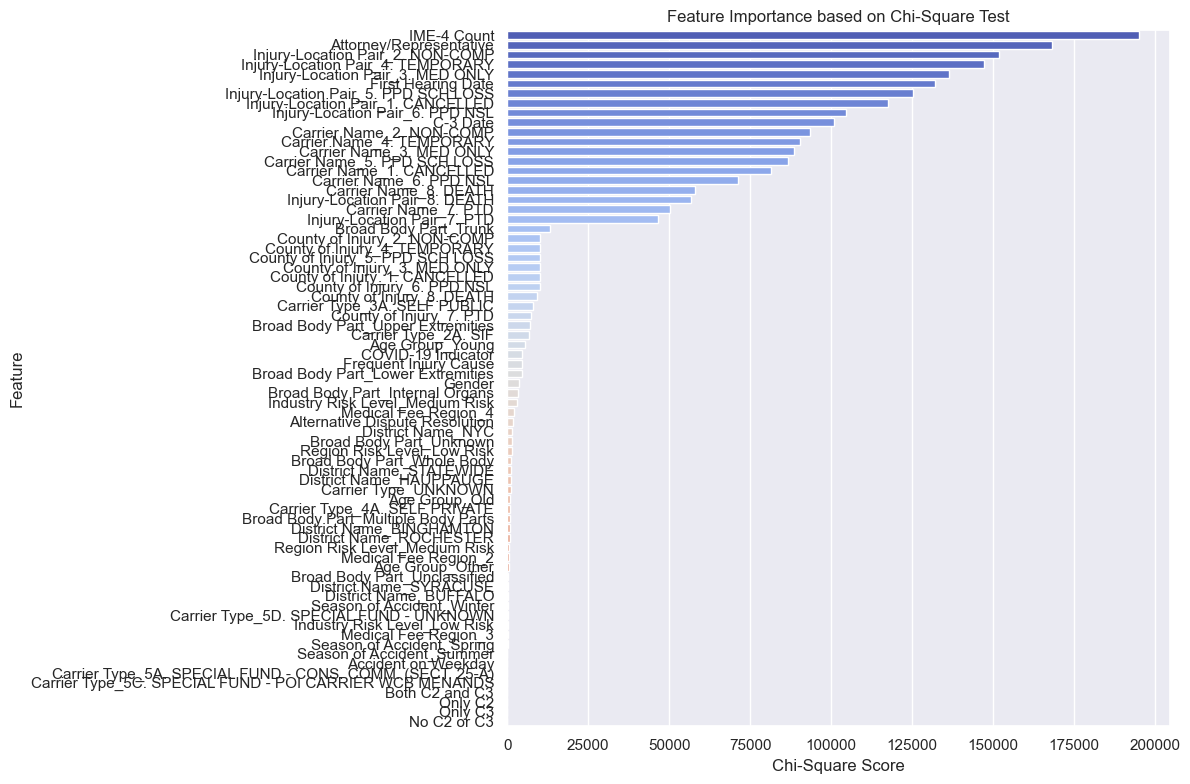

In [94]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Chi-Square Score', y='Feature', data=chi2_df, palette='coolwarm')
plt.title("Feature Importance based on Chi-Square Test")
plt.xlabel("Chi-Square Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

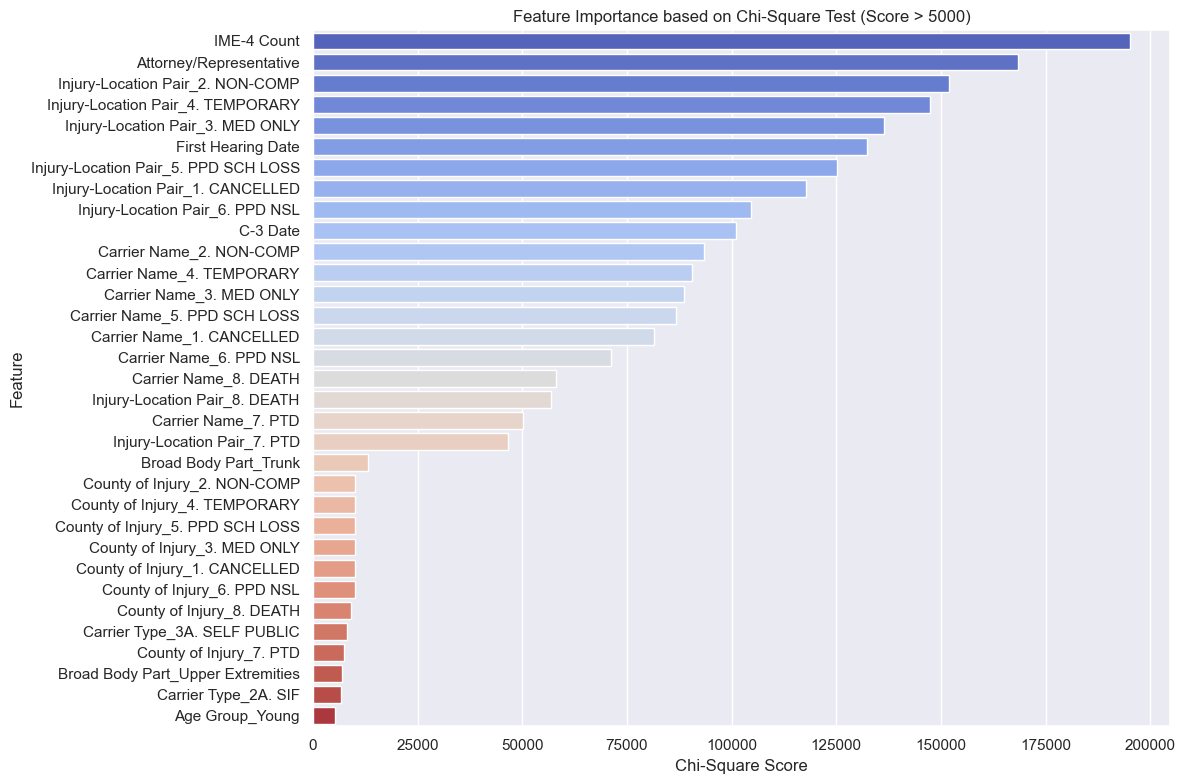

In [95]:
# Filter chi2_df for features with Chi-Square Score > 5000
filtered_chi2_df = chi2_df[chi2_df['Chi-Square Score'] > 5000]

plt.figure(figsize=(12, 8))
sns.barplot(x='Chi-Square Score', y='Feature', data=filtered_chi2_df, palette='coolwarm')
plt.title("Feature Importance based on Chi-Square Test (Score > 5000)")
plt.xlabel("Chi-Square Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [96]:
# Filter chi2_df for features with Chi-Square Score > 10000
high_chi2_df = chi2_df[chi2_df['Chi-Square Score'] > 100000]

# Print the filtered DataFrame
print("\nFeatures with Chi-Square Score > 10000:")
print(high_chi2_df)



Features with Chi-Square Score > 10000:
                                 Feature  Chi-Square Score Importance
59                           IME-4 Count     195057.824743  Important
61               Attorney/Representative     168389.701870  Important
44      Injury-Location Pair_2. NON-COMP     151890.699710  Important
46     Injury-Location Pair_4. TEMPORARY     147287.821418  Important
45      Injury-Location Pair_3. MED ONLY     136359.092488  Important
63                    First Hearing Date     132265.282745  Important
47  Injury-Location Pair_5. PPD SCH LOSS     125172.640703  Important
43     Injury-Location Pair_1. CANCELLED     117702.698859  Important
48       Injury-Location Pair_6. PPD NSL     104557.203504  Important
68                              C-3 Date     101009.404791  Important


After checking the plot, we can see that the chi2 values are very high for the 13/15.

Let's try and get the 10 features with the highest chi2 value. If needed we can try to optimize the number of features after testing the models

### **4.3.7 Mutual Information**

                                              Feature  \
59                                        IME-4 Count   
61                            Attorney/Representative   
63                                 First Hearing Date   
44                   Injury-Location Pair_2. NON-COMP   
46                  Injury-Location Pair_4. TEMPORARY   
..                                                ...   
22  Carrier Type_5A. SPECIAL FUND - CONS. COMM. (S...   
67                                     Both C2 and C3   
69                                            Only C2   
70                                            Only C3   
71                                        No C2 or C3   

    Mutual Information Score  
59                  0.218475  
61                  0.203687  
63                  0.160536  
44                  0.132132  
46                  0.130739  
..                       ...  
22                  0.000005  
67                  0.000000  
69                  0.000000  
70   

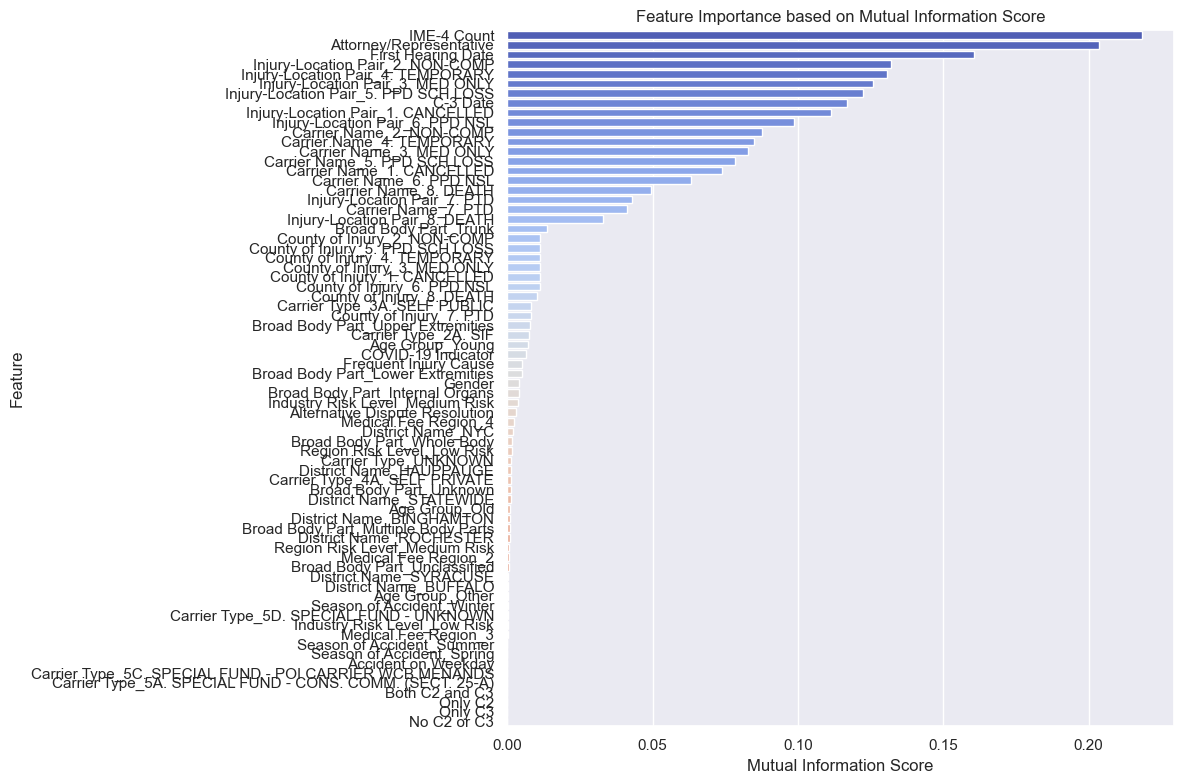

In [97]:
from sklearn.feature_selection import mutual_info_classif

def compute_mutual_information(X, y, feature_names):
    """
    Compute and visualize mutual information scores for features.
    
    Parameters:
        X (pd.DataFrame): Feature matrix (categorical/numerical features).
        y (pd.Series): Target variable.
        feature_names (list): List of feature names.
    
    Returns:
        pd.DataFrame: DataFrame containing features and their mutual information scores.
    """
    # Compute mutual information scores
    mi_scores = mutual_info_classif(X, y, discrete_features=True, random_state=42)

    # Create a DataFrame to store the scores
    feature_scores = pd.DataFrame({
        'Feature': feature_names,
        'Mutual Information Score': mi_scores
    })

    # Sort features by mutual information score
    feature_scores = feature_scores.sort_values(by='Mutual Information Score', ascending=False)

    # Display the top features
    print(feature_scores)

    # Plot the mutual information scores
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Mutual Information Score', y='Feature', data=feature_scores, palette='coolwarm')
    plt.title("Feature Importance based on Mutual Information Score")
    plt.xlabel("Mutual Information Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return feature_scores


# Example usage
# Assuming `X_train_categorical_encoded` is your encoded feature matrix (categorical features encoded as integers)
# and `y_` is your target variable.

feature_names = X_train_categorical_encoded.columns
mutual_info_results = compute_mutual_information(X_train_categorical_encoded, y_train_categorical_encoded, feature_names)

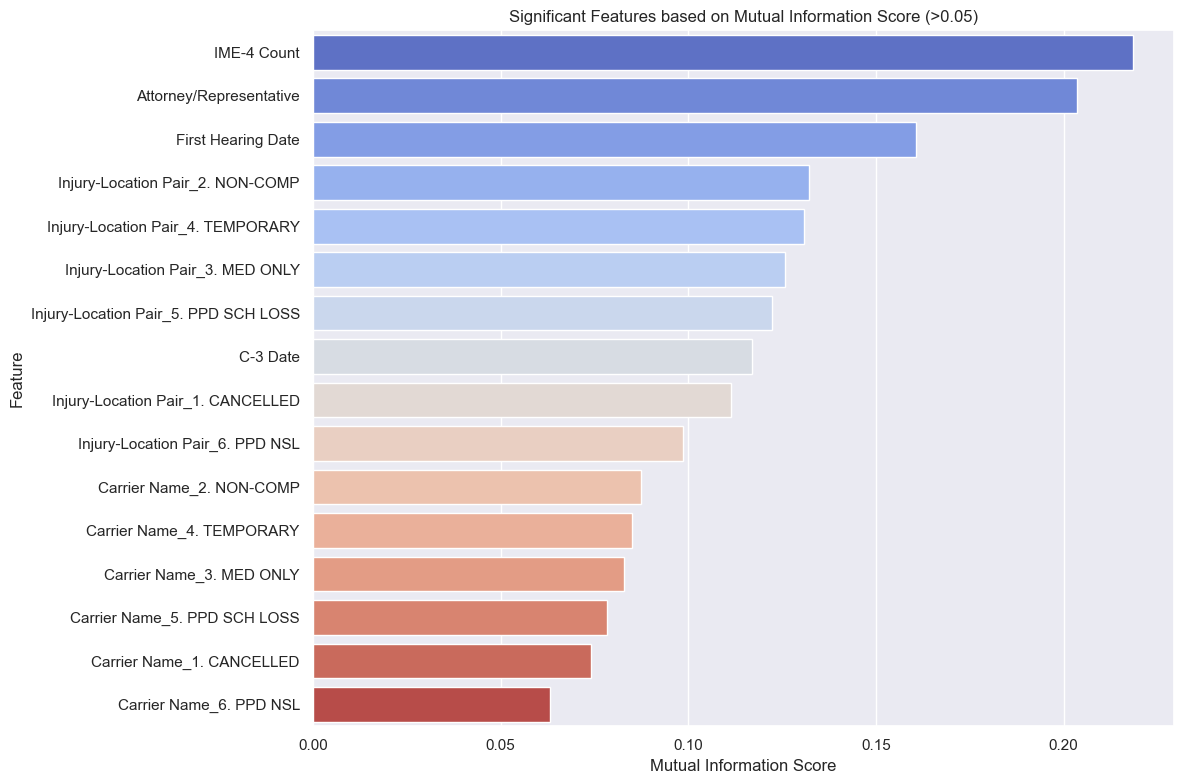

In [98]:
# Filter features with mutual information score above 0.05
significant_features = mutual_info_results[mutual_info_results['Mutual Information Score'] > 0.05]

# Plot the significant features
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information Score', y='Feature', data=significant_features, palette='coolwarm')
plt.title("Significant Features based on Mutual Information Score (>0.05)")
plt.xlabel("Mutual Information Score") 
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### **4.3.8 LASSO**

In [99]:
# Convert the categorical data (encoded) to a sparse format (CSR matrix)
X_train_sparse = csr_matrix(X_train_categorical_encoded)

# Initialize the Logistic Regression model with L1 penalty (Lasso regularization)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Train the Lasso model on the sparse training data and the encoded categorical target
lasso_model.fit(X_train_sparse, y_train_categorical_encoded)

# Extract the coefficients of the trained Lasso model (the importance of each feature)
coef_lasso = lasso_model.coef_[0]

# Create a DataFrame to associate each feature with its corresponding coefficient
# The coefficients represent the importance (magnitude) of each feature
feature_importances_lasso = pd.DataFrame({
    'Feature': X_train_categorical_encoded.columns,
    'Coefficient': coef_lasso
})

# Display the features sorted by their coefficients in descending order (most important features first)
print(feature_importances_lasso.sort_values(by='Coefficient', ascending=False))

                              Feature  Coefficient
43  Injury-Location Pair_1. CANCELLED    21.632668
11          Carrier Name_1. CANCELLED    10.263701
50      Injury-Location Pair_8. DEATH     1.110190
65              Frequent Injury Cause     0.881572
61            Attorney/Representative     0.733739
..                                ...          ...
12           Carrier Name_2. NON-COMP    -1.917417
27       County of Injury_2. NON-COMP    -2.055079
13           Carrier Name_3. MED ONLY    -2.074427
60     Alternative Dispute Resolution    -2.776144
59                        IME-4 Count   -30.967203

[72 rows x 2 columns]


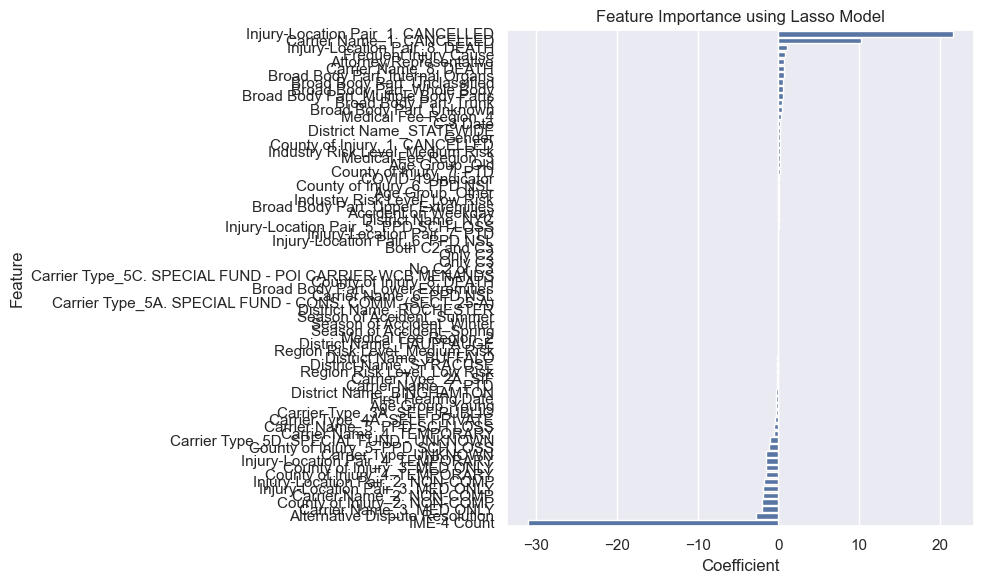

In [100]:
# plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importances_lasso.sort_values(by='Coefficient', ascending=False))
plt.title("Feature Importance using Lasso Model")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [101]:
#Can you give me the features with absolute value higher than 5
important_features = feature_importances_lasso[feature_importances_lasso['Coefficient'].abs() > 5]
print(important_features)


                              Feature  Coefficient
11          Carrier Name_1. CANCELLED    10.263701
43  Injury-Location Pair_1. CANCELLED    21.632668
59                        IME-4 Count   -30.967203


## Random Forest of all the features

In [102]:
# Initialize the RandomForestClassifier model with a fixed random state for reproducibility
rf_model = RandomForestClassifier(random_state=42)

# Train the RandomForest model on the encoded categorical features and the corresponding target variable
rf_model.fit(X_train_categorical_encoded, y_train_categorical_encoded)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_rf = pd.DataFrame({
    'Feature': X_train_categorical_encoded.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances_rf)

                                              Feature    Importance
59                                        IME-4 Count  8.157922e-02
61                            Attorney/Representative  6.799128e-02
63                                 First Hearing Date  4.349145e-02
44                   Injury-Location Pair_2. NON-COMP  4.033693e-02
46                  Injury-Location Pair_4. TEMPORARY  3.923236e-02
..                                                ...           ...
23  Carrier Type_5C. SPECIAL FUND - POI CARRIER WC...  5.634153e-08
67                                     Both C2 and C3  0.000000e+00
69                                            Only C2  0.000000e+00
70                                            Only C3  0.000000e+00
71                                        No C2 or C3  0.000000e+00

[72 rows x 2 columns]


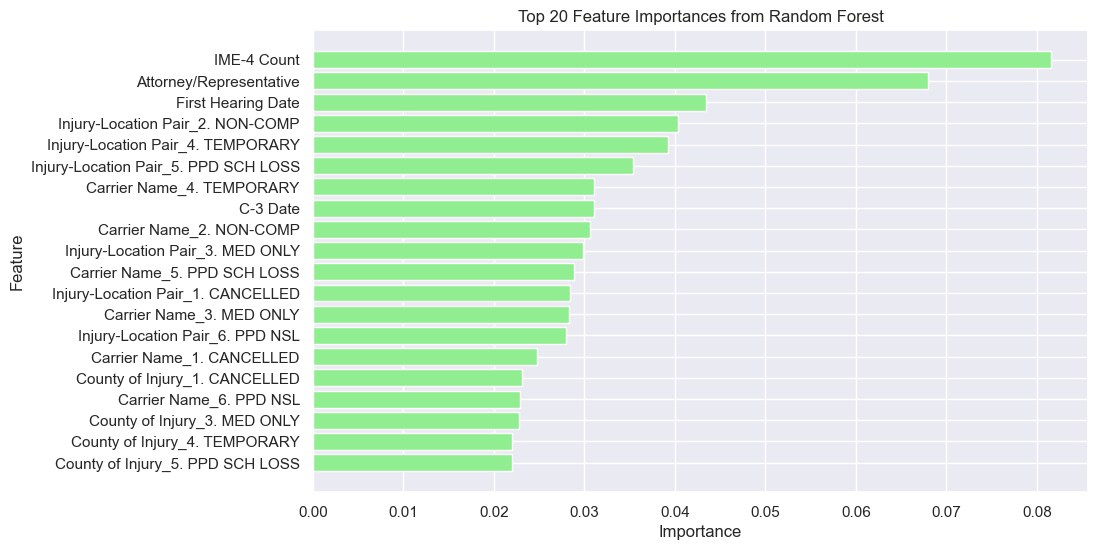

In [103]:
# plot feature importances for the first 20 features
plt.figure(figsize=(10, 6))
top_20_features = feature_importances_rf.head(20)
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # reverse the y-axis so that the most important feature is at the top
plt.show()


In [104]:
#Get the 10 most important features
top_rf_features = feature_importances_rf.head(10)

print(top_rf_features)

                                 Feature  Importance
59                           IME-4 Count    0.081579
61               Attorney/Representative    0.067991
63                    First Hearing Date    0.043491
44      Injury-Location Pair_2. NON-COMP    0.040337
46     Injury-Location Pair_4. TEMPORARY    0.039232
47  Injury-Location Pair_5. PPD SCH LOSS    0.035370
14             Carrier Name_4. TEMPORARY    0.031032
68                              C-3 Date    0.031025
12              Carrier Name_2. NON-COMP    0.030654
45      Injury-Location Pair_3. MED ONLY    0.029848


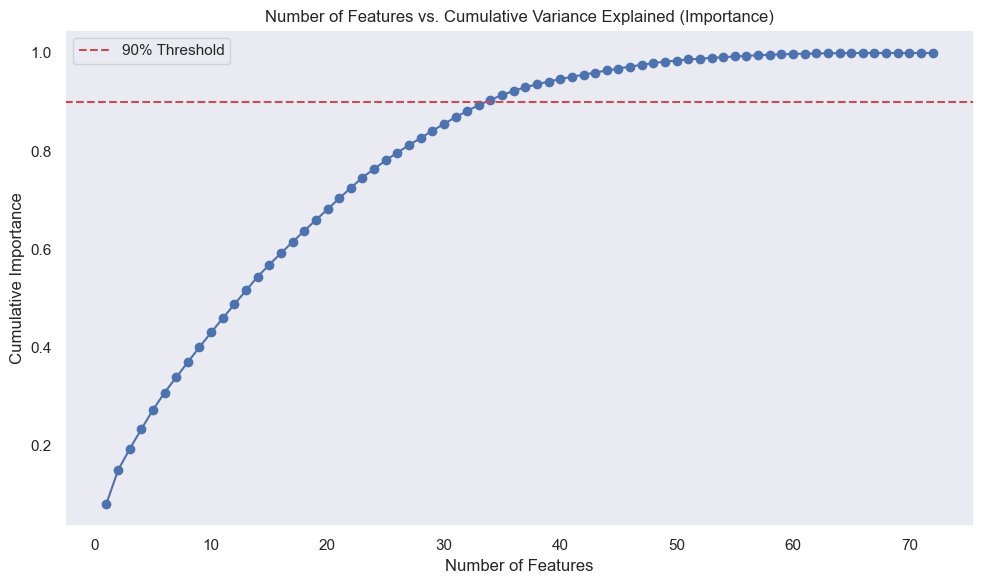

In [105]:
# Sort features by importance in descending order
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Compute cumulative importance
feature_importances_rf['Cumulative Importance'] = feature_importances_rf['Importance'].cumsum()

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(feature_importances_rf) + 1), feature_importances_rf['Cumulative Importance'], marker='o')
plt.title("Number of Features vs. Cumulative Variance Explained (Importance)")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.grid()
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Threshold")  # Optional: mark 90% threshold
plt.legend()
plt.tight_layout()
plt.show()

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

## **Numeric Features**
| Feature | Spearman | RFE LR | RFE CV | Lasso | Decision Tree | Gradient Boosting | Random Forest | What to do? |
|---------|----------|---------|---------|--------|---------------|-------------------|---------------|-------------|
| Age at Injury | ✓ | ✓ | ✗ | ✓ | ✓ | ✗  | ✓ | Keep |
| Average Weekly Wage | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | Keep |
| Birth Year | ✓ | ✓ | ✓ | ✗ | ✓ | ✗ | ✓ | Keep |
| Number of Dependents | ✗ | ✓ | ✓ | ✓ | ✗ | ✗ | ✗ | Discard |
| Accident Year | ✗ | ✓ | ✓ | ✓| ✗ | ✗ | ✗ | Discard |
| Assembly Year | ✗ | ✓ | ✓ | ✓ | ✗ | ✗ | ✗ | Discard |
| Dependency-to-Income Ratio | ✓ | ✓ | ✓| ✓ | ✓ | ✗ | ✓ | Keep |
| Time Between Events | ✓ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | Discard |
| C-2 Date Year | ✓ | ✓ | ✓| ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Accident Density | ✓ | ✗ | ✗ | ✓ | ✓ | ✗ | ✓ | Keep |
| Industry Claim Percentage | ✓ | ✗ | ✗ | ✓ | ✗ | ✗ | ✗ | Discard |
| Region Risk Percentage | ✓ | ✗ | ✓ | ✗ | ✗ | ✗ | ✗ | Discard |
| Geo-Industry Risk | ✓ | ✗ | ✗ | ✗ | ✓ | ✗ | ✓ | Discard |

## **Categorical Features**
| Feature | Chi-Square | Mutual Information | Lasso |Random Forest | What to do? |
|---------|------------|--------------------|--------|---------------|-------------|
| Age Group | ✗ | ✗ | ✗ | ✗ | Discard |
| Broad Body Part | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Name_1. CANCELLED | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Name_2. NON-COMP | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Name_3. MED ONLY | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Name_4. TEMPORARY | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Name_5. PPD SCH LOSS | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Name_6. PPD NSL | ✗ | ✗ | ✗ | ✗ | Discard | 
| Carrier Name_7. PTD | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Name_8. DEATH | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Type | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury | ✗ | ✗ | ✗ | ✗ | Discard |
| District Name | ✗ | ✗ | ✗ | ✗ | Discard |
| Industry Risk Level | ✗ | ✗ | ✗ | ✗ | Discard |
| Injury-Location Pair | ✗ | ✗ | ✗ | ✗ | Discard |
| Medical Fee Region | ✗ | ✗ | ✗ | ✗ | Discard |
| Region Risk Level | ✗ | ✗ | ✗ | ✗ | Discard |
| Season of Accident | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Type_2A. SIF | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Type_3A. SELF PUBLIC | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Type_4A. SELF PRIVATE | ✗ | ✗ | ✗ | ✗ | Discard |
| Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A) | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury_1. CANCELLED | ✗ | ✗ | ✓ | ✗ | Discard |
| County of Injury_2. NON-COMP | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury_3. MED ONLY | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury_4. TEMPORARY | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury_5. PPD SCH LOSS | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury_6. PPD NSL | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury_7. PTD | ✗ | ✗ | ✗ | ✗ | Discard |
| County of Injury_8. DEATH | ✗ | ✗ | ✗ | ✗ | Discard |
| Injury-Location Pair_1. CANCELLED | ✓ | ✓ | ✓ | ✗ | Keep |
| Injury-Location Pair_2. NON-COMP | ✓ | ✓ | ✗ | ✗ | Keep |
| Injury-Location Pair_3. MED ONLY | ✓ | ✓ | ✗ | ✗ | Keep |
| Injury-Location Pair_4. TEMPORARY | ✓ | ✓ | ✗ | ✗ | Keep |
| Injury-Location Pair_5. PPD SCH LOSS | ✓ | ✓ | ✗ | ✗ | Keep |
| Injury-Location Pair_6. PPD NSL | ✓ | ✗ | ✗ | ✗ | Discard |
| Injury-Location Pair_7. PTD | ✗ | ✗ | ✗ | ✗ | Discard |
| Injury-Location Pair_8. DEATH | ✗ | ✗ | ✗ | ✗ | Discard |


## **Binary Features**
| Feature | Chi-Square | Mutual Information | Lasso |Random Forest | What to do? |
|---------|------------|--------------------|-------|---------------|-------------|
| IME-4 Count | ✓ | ✓ | ✓ | ✓ | Keep |
| Alternative Dispute Resolution | ✗ | ✗ | ✗ | ✗ | Discard |
| Attorney/Representative | ✓ | ✓ | ✗| ✓ | Keep |
| COVID-19 Indicator | ✗ | ✗ | ✗ | ✗ | Discard |
| First Hearing Date | ✓ | ✓ | ✗| ✗ | Keep |
| Gender | ✗ | ✗ | ✗ | ✗ | Discard |
| Frequent Injury Cause | ✗ | ✗ | ✗ | ✗ | Discard |
| Accident on Weekday | ✗ | ✗ | ✗ | ✗ | Discard |
| Both C2 and C3 | ✗ | ✗ | ✗ | ✗ | Discard |
| C-3 Date | ✓ | ✓ | ✗| ✗ | Keep |
| Only C2 | ✗ | ✗ | ✗ | ✗ | Discard |
| Only C3 | ✗ | ✗ | ✗ | ✗ | Discard |
| No C2 or C3 | ✗ | ✗ | ✗ | ✗ | Discard |


## **Cyclic Features**
| Feature | Spearman | RFE LR | RFE CV | Lasso | Decision Tree | Gradient Boosting | Random Forest | What to do? |
|---------|----------|---------|---------|--------|---------------|-------------------|---------------|-------------|
| Accident Month (sin) | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | Discard |
| Accident Month (cos) | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | Discard |
| Assembly Month (sin) | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | Discard |
| Assembly Month (cos) | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | Discard |
| C-2 Date Month (sin) | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | Discard |
| C-2 Date Month (cos) | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | ✗ | Discard |

**Final Dataframe with features to keep**

In [106]:
numeric_features_chosen = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Dependency-to-Income Ratio', 'Carrier Accident Density']

categorical_features_chosen = ['Injury-Location Pair_1. CANCELLED', 'Injury-Location Pair_2. NON-COMP', 'Injury-Location Pair_3. MED ONLY', 'Injury-Location Pair_4. TEMPORARY', 'Injury-Location Pair_5. PPD SCH LOSS']

binary_features_chosen = ['IME-4 Count', 'Attorney/Representative', 'First Hearing Date', 'C-3 Date']

In [107]:
#Make the final datasets contain numeric_features_chosen and categorical_features_chosen

final_numerical_train = X_train_numeric_scaled[numeric_features_chosen]
final_categorical_train = X_train_categorical_encoded[categorical_features_chosen + binary_features_chosen]
final_df_train = pd.concat([final_numerical_train, final_categorical_train], axis=1)

final_numerical_val = X_val_numeric_scaled[numeric_features_chosen]
final_categorical_val = X_val_categorical_encoded[categorical_features_chosen + binary_features_chosen]
final_df_val = pd.concat([final_numerical_val, final_categorical_val], axis=1)

final_numerical_test = X_test_encoded[numeric_features_chosen]
final_categorical_test = X_test_encoded[categorical_features_chosen + binary_features_chosen]
final_df_test = pd.concat([final_numerical_test, final_categorical_test], axis=1)

In [108]:
final_df_train.to_csv('datasets/final_data_train_delivery1.csv', index=True)
final_df_val.to_csv('datasets/final_data_val_delivery1.csv', index=True)
final_df_test.to_csv('datasets/final_data_test_delivery1.csv', index=True)